In [1]:
import os
os.environ['KAGGLE_USERNAME']="simransohal"
os.environ['KAGGLE_KEY']="3aa7697cd9a4ba2a3715c4a29c0f0cb6"

In [2]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

sign-language-for-numbers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
with zipfile.ZipFile('sign-language-for-numbers.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.optim import Adam

import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torch
import torchvision

models = torchvision.models.mobilenet_v3_small(pretrained=False)

models.fc = nn.Linear(models.classifier[0].in_features, 11)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4772, 0.4772, 0.4772], std=[-0.3425, -0.3425, -0.3425]),
])

In [8]:
dataset = datasets.ImageFolder(r"Sign Language for Numbers", transform=preprocess)
train_size = int(0.7 * len(dataset))
val_size=int(0.1*len(dataset))
test_size = len(dataset) - (train_size+val_size)
train_dataset,validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,val_size,test_size])

In [9]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader=DataLoader(validation_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
optimizers =Adam(models.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()

In [11]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64

In [12]:
import time
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
models.to(device)
start_time=time.time()
for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    
    models.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizers.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = models(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizers.step()
        running_training_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1  }/{len(train_dataloader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_dataloader)
    epoch_training_accuracy = running_training_accuracy / len(train_dataloader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    models.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = models(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(train_dataloader)
    epoch_validation_accuracy = running_validation_accuracy / len(validation_dataloader.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))
print("#########Time Taken{}#########".format(time.time()-start_time))

Epoch [1/10], Step [100/181], Loss: 1.624948263168335
Epoch [1/10], Training Loss: 1.7734924347361147, Training Accuracy: 0.43385279178619385, Validation Loss: 0.42657056170932495, Validation Accuracy: 0.081212118268013
Epoch [2/10], Step [100/181], Loss: 0.3947657644748688
Epoch [2/10], Training Loss: 0.45389387888309046, Training Accuracy: 0.8506492972373962, Validation Loss: 0.5523201049362099, Validation Accuracy: 0.10060606151819229
Epoch [3/10], Step [100/181], Loss: 0.14506404101848602
Epoch [3/10], Training Loss: 0.20024008690816922, Training Accuracy: 0.9359306693077087, Validation Loss: 0.1791372243212073, Validation Accuracy: 0.6254545450210571
Epoch [4/10], Step [100/181], Loss: 0.15172548592090607
Epoch [4/10], Training Loss: 0.138930420108263, Training Accuracy: 0.9548917412757874, Validation Loss: 0.02988203450296465, Validation Accuracy: 0.9375757575035095
Epoch [5/10], Step [100/181], Loss: 0.009329674765467644
Epoch [5/10], Training Loss: 0.08444691444258334, Training

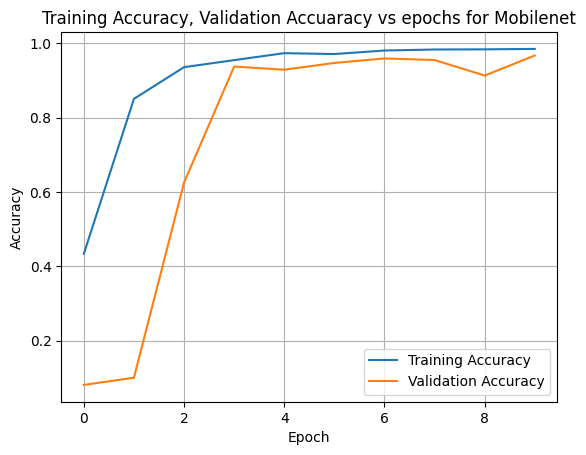

In [16]:
training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuaracy vs epochs for Mobilenet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Test Accuracy: 0.9636363636363636
[[293   0   3   0   0   0   0   0   0   0   1]
 [  0 285   3   0   0   0   0   0   0   0   1]
 [  0   3 297   0   0   0   8   0   0   0   0]
 [  0   1   4 261   0   0   0   1   0   0   5]
 [  1   0   1   0 262   0   5   7   2   1   6]
 [  0   0   0   1   1 293   0   0   0   0   3]
 [  1   0   3   0   1   0 307   0   0   0   4]
 [  0   1   7   1   0   0   0 308   2   0   1]
 [  1   2   0   0   0   0   0   1 303   3   0]
 [  0   0   0   0   0   0   0   0   2 290   1]
 [  8  19   1   0   0   0   0   1   1   1 281]]


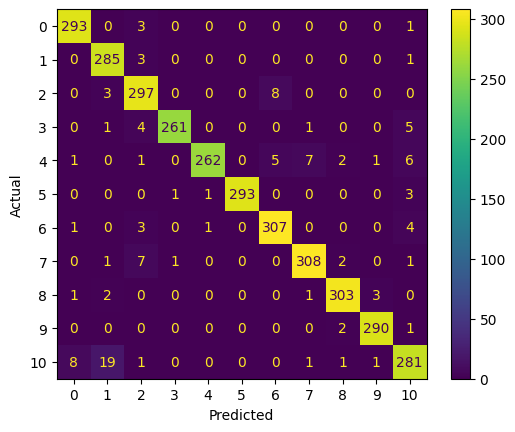

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       297
           1       0.92      0.99      0.95       289
           2       0.93      0.96      0.95       308
           3       0.99      0.96      0.98       272
           4       0.99      0.92      0.95       285
           5       1.00      0.98      0.99       298
           6       0.96      0.97      0.97       316
           7       0.97      0.96      0.97       320
           8       0.98      0.98      0.98       310
           9       0.98      0.99      0.99       293
          10       0.93      0.90      0.91       312

    accuracy                           0.96      3300
   macro avg       0.96      0.96      0.96      3300
weighted avg       0.96      0.96      0.96      3300



In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

models.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = models(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

#target_names = list(data_loader_train.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
#sns.heatmap(cm, annot=True, cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3300 samples in 0.001s...
[t-SNE] Computed neighbors for 3300 samples in 0.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3300
[t-SNE] Computed conditional probabilities for sample 2000 / 3300
[t-SNE] Computed conditional probabilities for sample 3000 / 3300
[t-SNE] Computed conditional probabilities for sample 3300 / 3300
[t-SNE] Mean sigma: 1.400461
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.221596
[t-SNE] KL divergence after 2000 iterations: 0.743266


<ipython-input-17-56d6b030b23e>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names)-1)
<ipython-input-17-56d6b030b23e>:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))


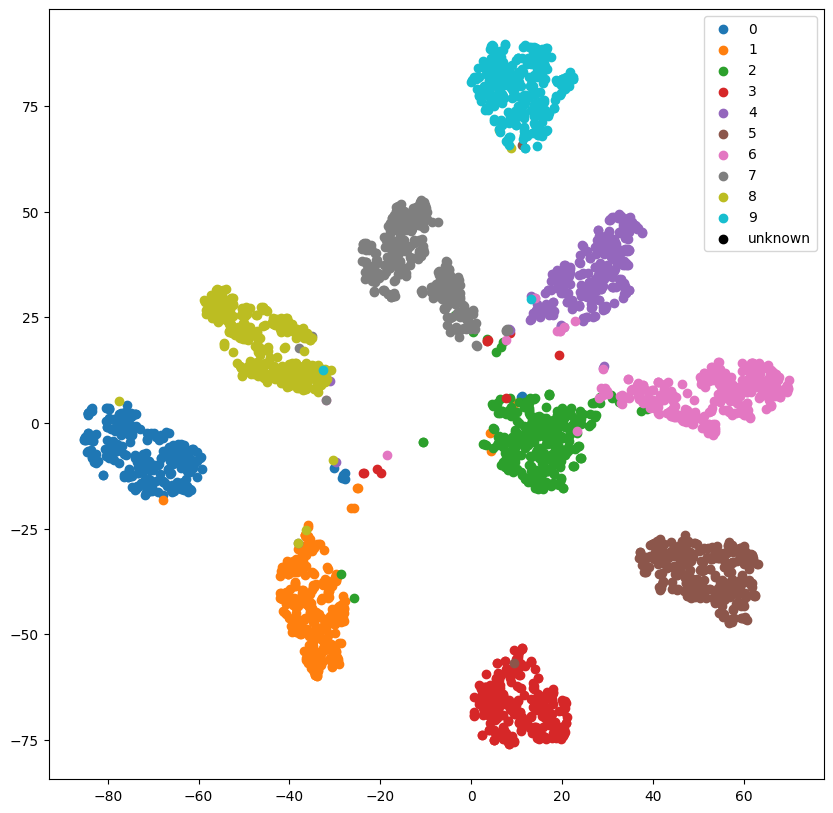

In [17]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

models.to('cuda')

models = torch.nn.Sequential(*(list(models.children())[:-1]))

models.eval()

features = []
labels = []
for images, target in test_dataloader:
    images = images.to('cuda')
    with torch.no_grad():
        output = models(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# reshape the features array to have two dimensions
n_samples = features.shape[0]
n_features = np.prod(features.shape[1:])
features = features.reshape((n_samples, n_features))

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(dataset.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names)-1)

u = False

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()
